# Predicting Wine Quality Score

**Authors**: Xander Dawson, Zackarya Hamza, Sid Ahuja

In [94]:
library(tidyverse, quietly = TRUE)
library(tidymodels, quietly = TRUE)
library(repr, quietly = TRUE)
library(GGally, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(psych, quietly = TRUE)
library(kknn, quietly = TRUE)

## Summary

- Do last after discussion
- See breast cancer summary example
- Talk about the model we use (kNN) to predict wine quality using chemical compositions of the wine
- Discuss performance of final classifier
- Discuss the implications of the score --> if its' a good or bad score, how does it impact wine quality predictions in the real world
- Talk about whether the model is ready to deploy or still needs work

## Introduction

- Remember to include references
- Start by talking about wine quality and how it depends on many chemical and physical factors
- Include details about subjectivity and governing bodies/organizations that categorize and grade wine quality (in out project, it's the CVRVV commission of Portugal that has determined the qualities of the wines)
- Next paragraph:
- Open paragraph by talking about what we are doing in this report --> our goal is to use a classification model to predict wine quality based on several chemical measurements of the wine
- We are focusing on white wines in this report
- This has many implications in wine making and in the wine business where it is important to make good quality wine by understanding which additives and wine properties increase quality
- Additionally, wine buyers can use this model to buy good quality wines without having to try every single wine prior to purchasing (idk feel free to add any BS here)
- others can also input there own quality scores to get personalized models
- See breast cancer intro for more ideas

## Methods and Results

### Data

In order to explore and build a wine quality classification model, we are using the wine quality data set sourced from the UCI Machine Learning Repository and created by P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis from the University of Minho in Portugal (Cortez et al., 2009). Specifically, we are interested in predicting white wine quality based on the chemical composition of the wine. Each row represents a white wine and the chemical measurements taken from the wine and there are 4898 samples in the dataset. The target value (integer wine quality score) was determined by the Vinho Verde Wine Commission (CVRVV) of Portugal.

| Feature | Type | Description|
|:---:|:---:|:---:|
| Fixed Acitity | Coninuous | Concentration (g/L) of tartaric acid.<br />Impacts the tartness of wines. |
| Volatile Acitity | Coninuous | Concentration (g/L) of acetic acid.<br />Impacts the vinegar-like taste in wines. |
| Citric Acid | Coninuous | Concentration (g/L) of citric acid.<br />Impacts the freshness of wines. |
| Residual Sugar | Coninuous | Concentration (g/L) of sugar remaining after fermentation.<br />Impacts the sweetness of wines. |
| Chlorides | Coninuous | Concentration (g/L) of chlorides.<br />Impacts the saltiness of wines. |
| Free Sulfur Dioxide | Coninuous | Concentration (mg/L) of unbound SO2.<br />Prevents microbial growth. |
| Total Sulfur Dioxide | Coninuous | Concentration (mg/L) of total SO2.<br />Prevents microbial growth and impacts aroma/taste. |
| Density | Coninuous | Density (g/mL) measurement.<br />Relates alcohol to sugar content. |
| pH | Coninuous | Measurement of wine acidity. | 
| Suphates | Coninuous | Concentration (mg/L) of total sulphates. |
| Alcohol | Coninuous | Percentage (%) of alcohol content. |

### Analysis

To predict the wine quality, we utilized the k-nearest neighbors (k-nn) algorithm and built a classification model based on certain features within the dataset (excluding **ADD FEATURES WE DID NOT USE**). First we converted the quality_score target column into a quality_class column where scores 0-5 were considered bad and scores 6-10 were considered good. We did this to reduce the number of target classes, allowing for more examples within each class. Then we split the data into train (70%) and test splits (30%). All selected features were scaled prior to model training. `[*** insert cross-validation and hyperparameter tuning information here]`. The R programming language (R Core Team, 2023) and the tidyverse(Wickham et al., 2019) and tidymodels(Kuhn et al., 2020) R packages were used to perform the analysis

In [2]:
# data downloaded as zip from UCI Machine Learning Repository and unzipped file is moved to /data
url <- "https://archive.ics.uci.edu/static/public/186/wine+quality.zip"
temp <- tempfile()
download.file(url, temp)
unzip(temp, exdir = "./data/raw")

In [54]:
# preprocessing data
# read csv file and replace column header
white_wine <- read_delim("data/raw/winequality-white.csv", delim = ";", show_col_types = FALSE)
colnames(white_wine) <- c("fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", 
                          "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", 
                          "pH", "sulphates", "alcohol", "quality_score")

# changing quality_score to quality_category
white_wine <- white_wine %>% 
    mutate(quality_category = case_when(
        quality_score <= 5 ~ "bad",
        quality_score <= 10 ~ "good")) %>%
    mutate(quality_category = as_factor(quality_category)) %>%
    select(-quality_score)

head(white_wine)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_category
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,good
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,good
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,good
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,good
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,good
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,good


In [55]:
# creating the train and test splits
set.seed(123)
wine_split <- initial_split(white_wine, prop = 0.70, strata = quality_category)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

write_csv(wine_train, "data/processed/white_wine_train.csv")
write_csv(wine_test, "data/processed/white_wine_test.csv")

In [56]:
# feature scaling recipe
wine_preprocess_recipe <- recipe(quality_category ~ ., data = wine_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

prep_preprocess_recipe <- prep(wine_preprocess_recipe, training = wine_train)

scaled_wine_train <- bake(prep_preprocess_recipe, new_data = wine_train)
scaled_wine_test <- bake(prep_preprocess_recipe, new_data = wine_test)

write_csv(scaled_wine_train, "data/processed/scaled_white_wine_train.csv")
write_csv(scaled_wine_test, "data/processed/scaled_white_wine_test.csv")

# note for model training

In [57]:
describe(wine_train) %>%
    select(n, mean, sd, median, min, max, range)

,n,mean,sd,median,min,max,range
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fixed_acidity,3428,6.8610852,0.844966345,6.8000,3.80000,11.80000,8.00000
volatile_acidity,3428,0.2791861,0.100624153,0.2600,0.08000,1.10000,1.02000
citric_acid,3428,0.3345595,0.121450521,0.3200,0.00000,1.66000,1.66000
residual_sugar,3428,6.4405338,5.114220330,5.2250,0.70000,65.80000,65.10000
chlorides,3428,0.0461902,0.022244628,0.0430,0.00900,0.30100,0.29200
free_sulfur_dioxide,3428,35.4457410,16.532028564,34.0000,3.00000,146.50000,143.50000
total_sulfur_dioxide,3428,138.5088973,42.551564965,134.0000,9.00000,366.50000,357.50000
density,3428,0.9940593,0.003027409,0.9938,0.98711,1.03898,0.05187
pH,3428,3.1858022,0.150552037,3.1700,2.74000,3.82000,1.08000


In [58]:
num_obs <- nrow(wine_train)
summary <- wine_train %>%
        group_by(quality_category) %>%
        summarize(
            count = n(),
            percentage = n() / num_obs * 100,
            fixed_acidity_avg = mean(fixed_acidity),
            volatile_acidity_avg = mean(volatile_acidity),
            citric_acid_avg = mean(citric_acid),
            residual_sugar_avg = mean(residual_sugar),
            chlorides_avg = mean(chlorides),
            free_sulfur_dioxide_avg = mean(free_sulfur_dioxide),
            total_sulfur_dioxide_avg = mean(total_sulfur_dioxide),
            density_avg = mean(density),
            pH_avg = mean(pH),
            sulphates_avg = mean(sulphates),
            alcohol_avg = mean(alcohol)
        )
summary

quality_category,count,percentage,fixed_acidity_avg,volatile_acidity_avg,citric_acid_avg,residual_sugar_avg,chlorides_avg,free_sulfur_dioxide_avg,total_sulfur_dioxide_avg,density_avg,pH_avg,sulphates_avg,alcohol_avg
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
good,2280,66.51109,6.801272,0.2626930,0.3348289,6.086667,0.04320833,35.61009,133.5763,0.9934838,3.195110,0.4903860,10.83645
bad,1148,33.48891,6.979878,0.3119425,0.3340244,7.143336,0.05211237,35.11934,148.3053,0.9952022,3.167317,0.4802787,9.84698


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


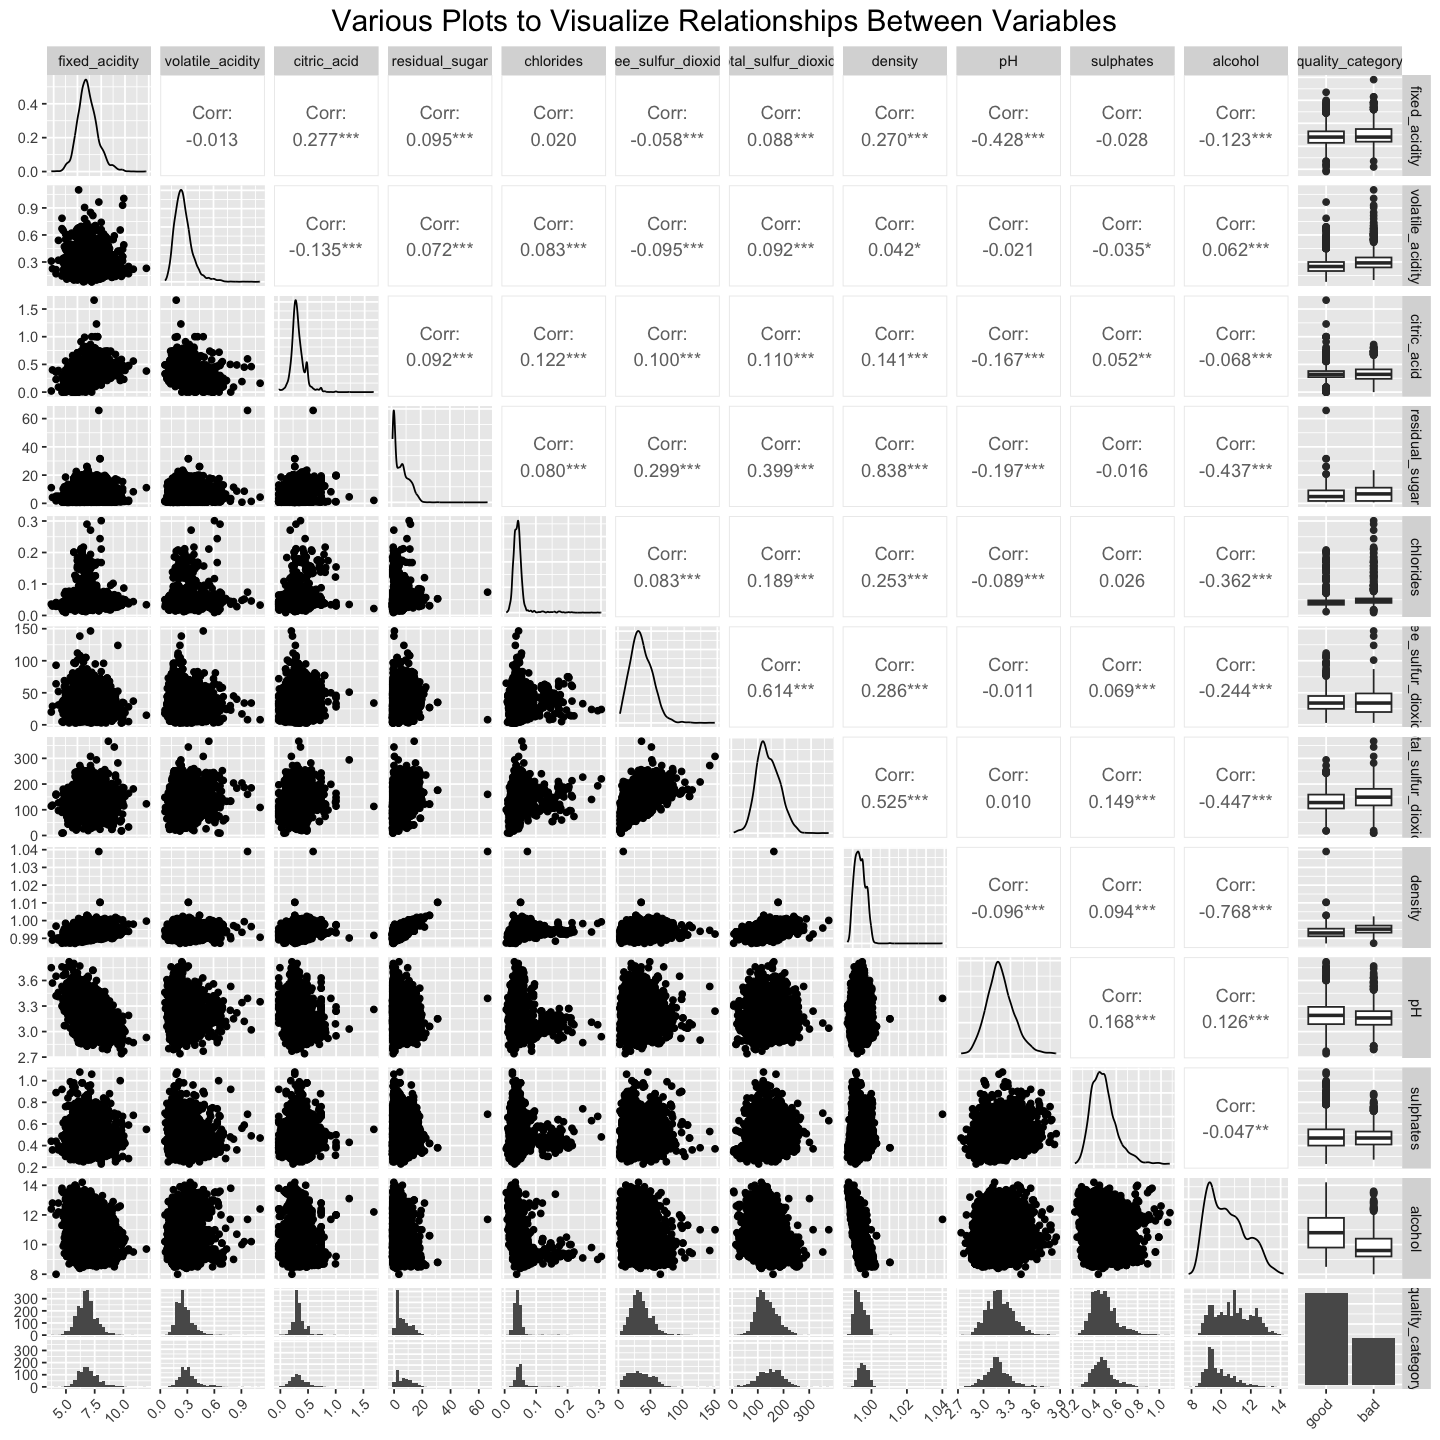

In [59]:
# visualizing data in a graph

options(repr.plot.width=12, repr.plot.height=12)

plot <- wine_train %>%
        ggpairs() +
        theme(axis.text.x=element_text(angle = 45, hjust = 1)) +
        ggtitle("Various Plots to Visualize Relationships Between Variables") +
        theme(plot.title = element_text(size = 18, hjust = 0.5))
plot

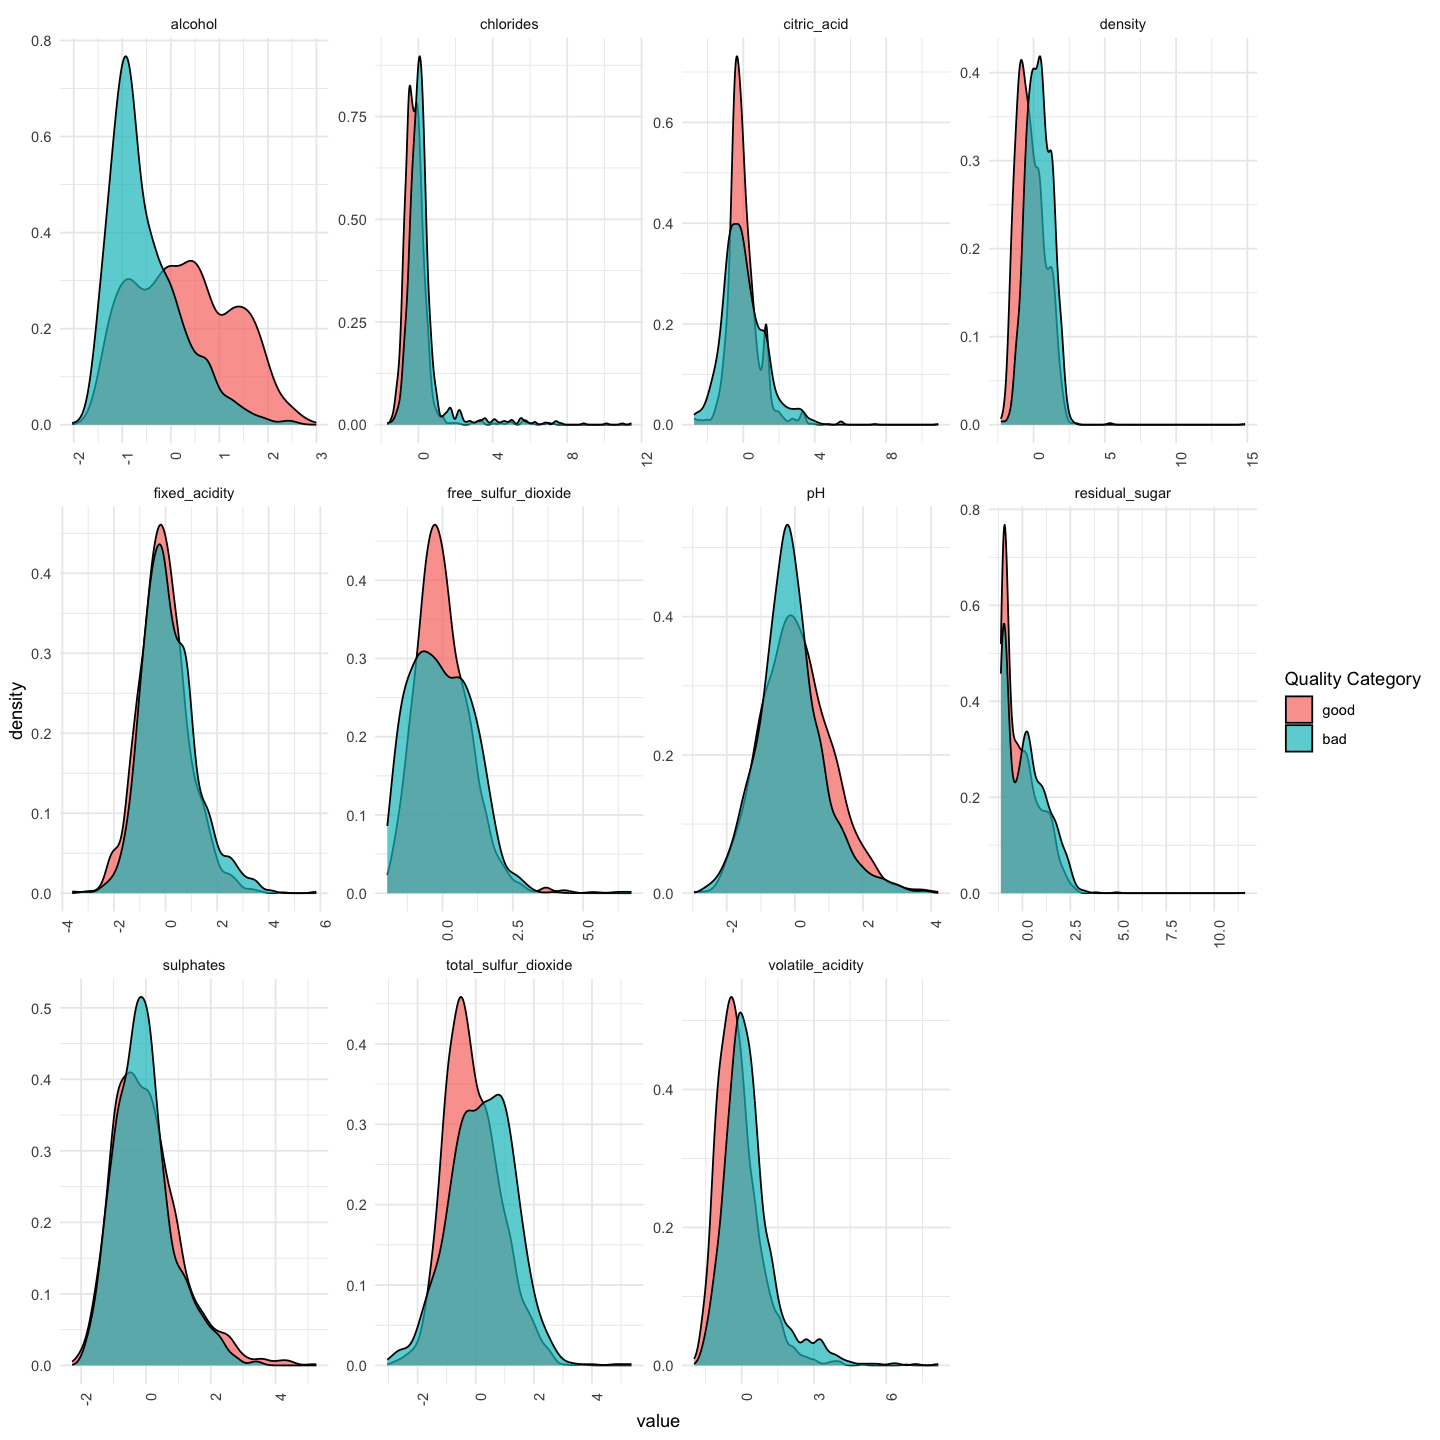

In [62]:
scaled_wine_train_long <- scaled_wine_train %>%
                gather(key = "predictor", value = "value", -quality_category)

ggplot(scaled_wine_train_long, aes(x = value, fill = quality_category)) +
    geom_density(alpha = 0.7) +
    facet_wrap(~predictor, scales = "free") +
    theme_minimal() +
    labs(fill = "Quality Category") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [85]:
wine_recipe <- recipe(quality_category ~ alcohol + chlorides + volatile_acidity + 
                      total_sulfur_dioxide + density + citric_acid + pH,
                      data = wine_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality_category)

In [81]:
knn_spec <- nearest_neighbor(weight_func = "optimal",
                             neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

In [82]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() %>%
            add_recipe(wine_recipe) %>%
            add_model(knn_spec) %>%
            tune_grid(resamples = wine_vfold, grid = k_vals) %>%
            collect_metrics()

accuracies <- knn_results %>%
            filter(.metric == "roc_auc")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,roc_auc,binary,0.7367654,5,0.006950809,Preprocessor1_Model01
6,roc_auc,binary,0.8076486,5,0.008150955,Preprocessor1_Model02
11,roc_auc,binary,0.8162696,5,0.008798642,Preprocessor1_Model03
16,roc_auc,binary,0.8188549,5,0.008815880,Preprocessor1_Model04
21,roc_auc,binary,0.8184582,5,0.008023511,Preprocessor1_Model05
26,roc_auc,binary,0.8175070,5,0.007367614,Preprocessor1_Model06
31,roc_auc,binary,0.8155513,5,0.006839000,Preprocessor1_Model07
36,roc_auc,binary,0.8136958,5,0.006345905,Preprocessor1_Model08
41,roc_auc,binary,0.8120973,5,0.006059147,Preprocessor1_Model09


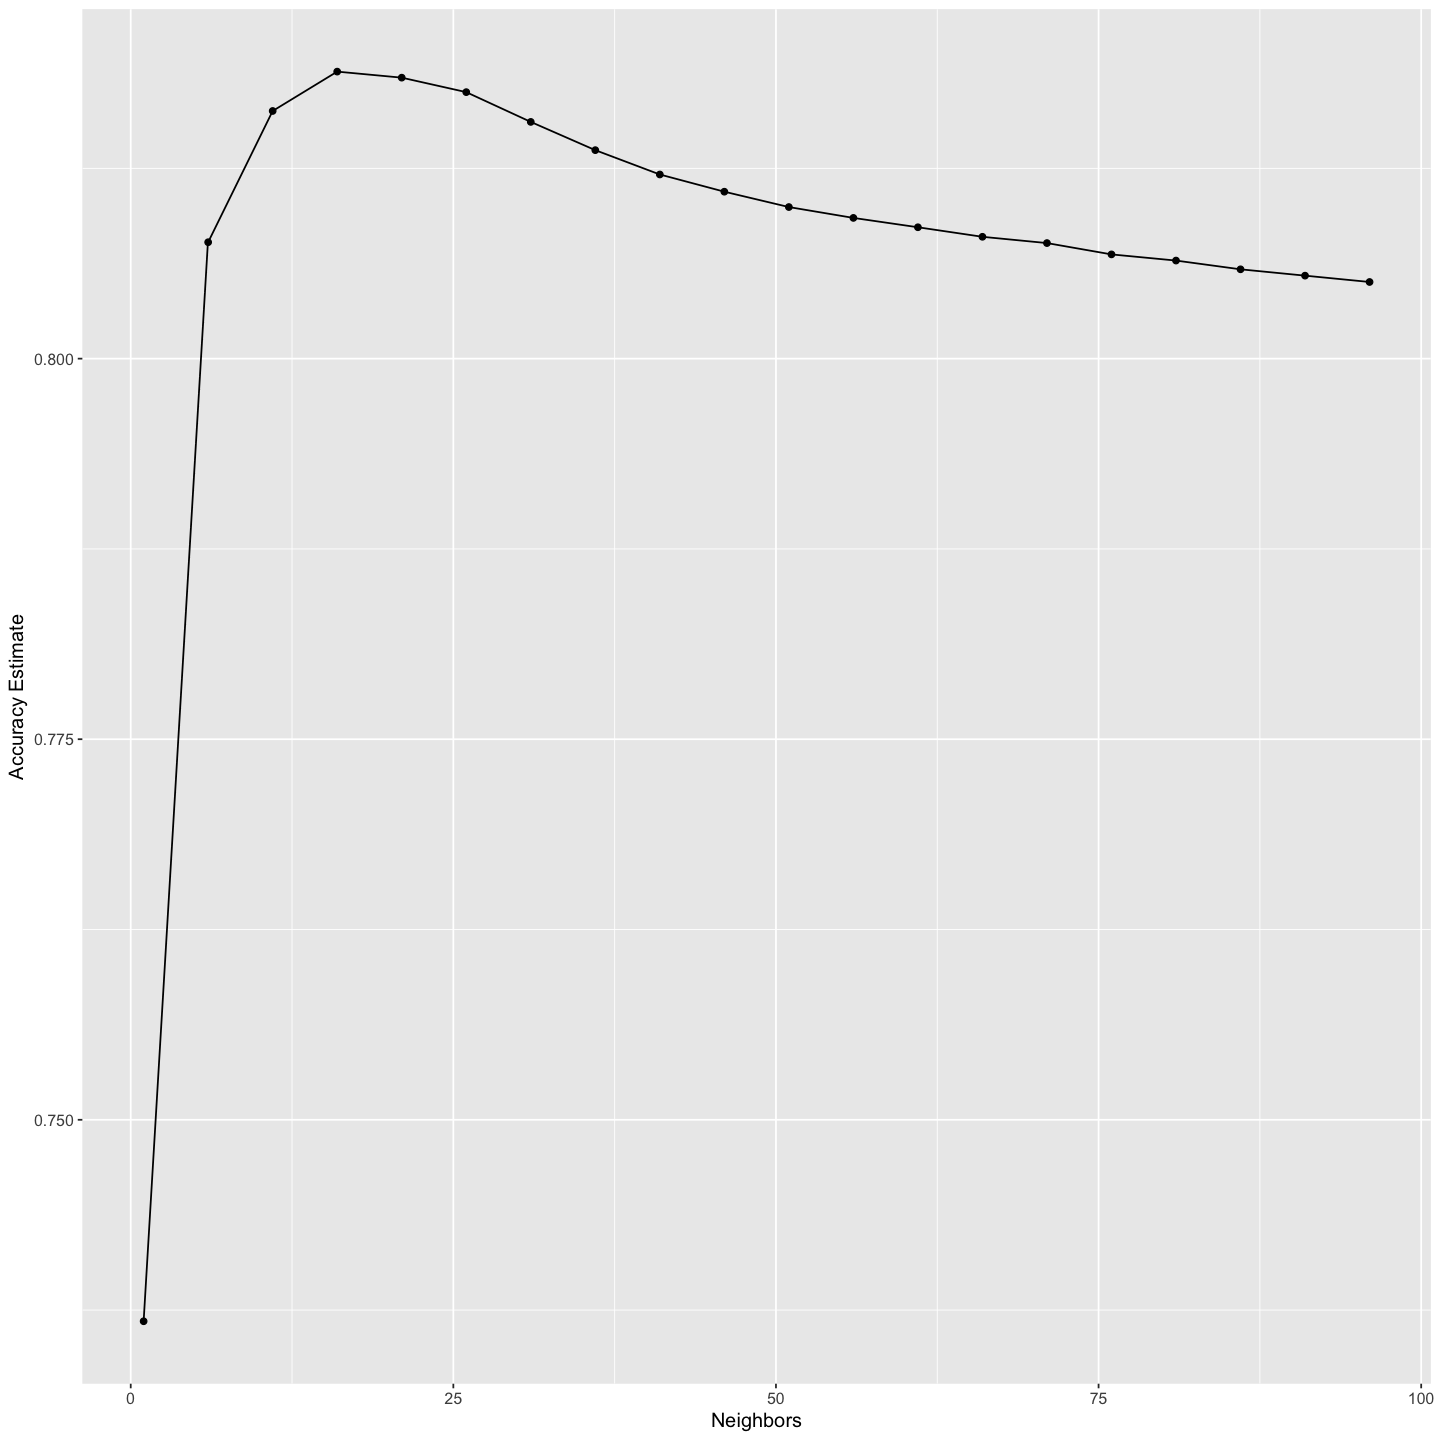

In [83]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors", y = "Accuracy Estimate") +
                theme(text = element_text(size = 12))

accuracy_vs_k

In [84]:
best_k <- accuracies %>%
        arrange(desc(mean)) %>%
        head(1) %>%
        pull(neighbors)
best_k

[1] 16

In [86]:
# building classification model using best k value
wine_recipe <- recipe(quality_category ~ alcohol + chlorides + volatile_acidity + 
                      total_sulfur_dioxide + density + citric_acid + pH,
                      data = wine_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "optimal",
                             neighbors = best_k) %>%
            set_engine("kknn") %>%
            set_mode("classification")

knn_fit <- workflow() %>%
    add_recipe(wine_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = wine_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(16,     data, 5), kernel = ~"optimal")

Type of response variable: nominal
Minimal misclassification: 0.2287048
Best kernel: optimal
Best k: 16

In [90]:
# evaluating on test set
wine_test_predictions <- predict(knn_fit, wine_test) %>%
    bind_cols(wine_test)

wine_test_predictions %>%
    metrics(truth = quality_category, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7843537


In [91]:
wine_test_predictions %>%
    precision(truth = quality_category, estimate = .pred_class, event_level="first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8063021


In [92]:
wine_test_predictions %>%
    recall(truth = quality_category, estimate = .pred_class, event_level="first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.8895706


In [93]:
confusion <- wine_test_predictions %>%
             conf_mat(truth = quality_category, estimate = .pred_class)
confusion

          Truth
Prediction good bad
      good  870 209
      bad   108 283

## Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References

blank